# MS/MS parser

This notebook was created for purpose of parsing MS/MS data. It was needed for creation of canonical smiles from CAS number or InChiKey or names.
All these information were downloaded from PubChem with help of PubChempy package. And SMILES were chosen from logic in function determine_general_smiles.


Also original nist_msms contains unidentifiable attributes with name $Synon: two_numbers, which were then translated into this mapping:

    '00': 'fragmentation_level',
    '03': 'adduct',
    '04': 'mass',  # Unclear, keep name as 'mass'
    '05': 'collision_energy',
    '06': 'instrument_type',
    '07': 'instrument_model',
    '08': 'ion_acquisition_mode',
    '09': 'chromatography_setup',
    '10': 'ionization_mode',
    '11': 'polarity',
    '12': 'collision_gas',
    '13': 'collision_cell_pressure',
    '16': 'unknown_16',
    '17': 'additional_info',
    '18': 'unknown_18',
    '24': 'unknown_24',
    '28': 'inchikey',
    '30': 'transition_monitoring'
    
Result is then spectrum file .msp which contain parsed spectrum metadata (such as smiles, adducts, etd.) and spectrum
    


In [134]:
from matchms.importing import load_from_msp
import numpy as np
import os
import random

In [2]:
from matchms.importing import load_from_msp
from matchms.exporting import save_as_msp
from matchms import Spectrum
from pubchempy import get_compounds
import json
import matchms

import pandas as pd
from rdkit import Chem
from rdkit.Chem import inchi


import math
import numpy as np
import os
import random
import pandas as pd
import time

import matplotlib.pyplot as plt
import re
from collections import defaultdict

In [4]:
FILE_PATH_MS = '../data/NIST/nist_msms.MSP'
FILE_PATH_MS2 = '../data/NIST/nist_msms2.MSP'

NUM_OF_MS_SPEC = 574826
NUM_OF_MS2_SPEC = 90244

## Custom parser

In [6]:
def parse_msp_synon(file_path):
    """
    Parses an MSP file to extract spectra information, specifically focusing on 'Synon' fields
    prefixed with '$:' entries. Each spectrum is identified by a unique NISTNO (NIST number).
    
    The function reads the MSP file line-by-line, identifies each spectrum based on the "Name:" 
    line, and associates 'Synon' entries with two-digit codes from the '$:' prefix with their
    respective NISTNO. The extracted data is organized in a dictionary where keys are NISTNOs and
    values are dictionaries containing 'Synon' attributes, CASNO, and Name.

    Parameters:
    file_path (str): The path to the MSP file to be parsed.

    Returns:
    dict: A dictionary where each key is a NISTNO (unique identifier for each spectrum) and each
          value is another dictionary containing 'Synon' attributes (with two-digit codes as keys
          and their corresponding values), CASNO, and Name.

    Example:
    If the input file contains:
    Name: Example Compound
    NISTNO: 123456
    CASNO: 123456789
    Synon: $:03[M+H]+
    Synon: $:06IT/ion trap
    
    The output will be:
    {
        '123456': {
            'name': 'Example Compound',
            'casno': '123456789',
            'synon': {
                '03': '[M+H]+',
                '06': 'IT/ion trap'
            }
        }
    }

    """
    spectra_data = {}
    current_spectrum = None
    synon_dict = {}

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            # Start a new spectrum entry when encountering a Name line
            if line.startswith("Name:"):
                # Save the current spectrum's data if it exists
                if current_spectrum:
                    nistno = current_spectrum.get('nistno')
                    if nistno:
                        spectra_data[nistno] = {
                            'name': current_spectrum.get('compound_name', 'N/A'),
                            'casno': current_spectrum.get('casno', 'N/A'),
                            'synon': synon_dict
                        }
                # Initialize a new spectrum
                current_spectrum = {"compound_name": line.split(": ", 1)[1]}
                synon_dict = {}  # Reset Synon attributes for the new spectrum

            elif line.startswith("NISTNO:"):
                # Ensure current_spectrum is not None
                if current_spectrum is not None:
                    # Capture NISTNO for unique identification
                    current_spectrum['nistno'] = line.split(": ", 1)[1]

            elif line.startswith("CASNO:"):
                # Ensure current_spectrum is not None and capture CASNO
                if current_spectrum is not None:
                    current_spectrum['casno'] = line.split(": ", 1)[1] 

            elif line.startswith("Synon: $:"):
                # Extract the two-digit code and the corresponding value
                match = re.match(r"Synon: \$:(\d{2})(.*)", line)
                if match and current_spectrum is not None:
                    code = match.group(1)
                    value = match.group(2).strip()
                    synon_dict[code] = value  # Store the code and value in the dictionary

        # Save the last spectrum if the file does not end with a new 'Name:' line
        if current_spectrum and 'nistno' in current_spectrum:
            nistno = current_spectrum['nistno']
            spectra_data[nistno] = {
                'name': current_spectrum.get('compound_name', 'N/A'),
                'casno': current_spectrum.get('casno', 'N/A'),
                'synon': synon_dict
            }

    return spectra_data

In [7]:
# Parse the file
parsed_spectra = parse_msp_synon(FILE_PATH_MS)

In [9]:
# Check if num of instances in original file and parsed dictionary differs
len(parsed_spectra) == NUM_OF_MS_SPEC

True

In [10]:
len(parsed_spectra)

574826

In [13]:
def validate_and_count_attr(parsed_spectra): 
    """
    Function to print base statistics of parsed Synon attributes from the parsed_spectra dictionary.
    
    :param parsed_spectra: dictionary from parse_msp_synon function with structure:
                           {
                               'NISTNO': {
                                   'name': 'Compound Name',
                                   'casno': 'CAS Number',
                                   'synon': {
                                       'Attribute Code': 'Value',
                                       ...
                                   }
                               },
                               ...
                           }
    :return: None
    """

    min_synon_count = float('inf')
    max_synon_count = 0
    attribute_counts = defaultdict(int)
    unique_attributes = set()
    
    for nistno, spectrum in parsed_spectra.items():
        synon_dict = spectrum.get('synon', {})
        synon_count = len(synon_dict)

        min_synon_count = min(min_synon_count, synon_count)
        max_synon_count = max(max_synon_count, synon_count)

        for attribute in synon_dict.keys():
            unique_attributes.add(attribute)
            attribute_counts[attribute] += 1

    print(f"Minimum number of Synon attributes per spectrum: {min_synon_count}")
    print(f"Maximum number of Synon attributes per spectrum: {max_synon_count}")

    print("\nUnique attribute names and their occurrences:")
    for attribute, count in sorted(attribute_counts.items()):
        print(f"Attribute {attribute}: {count} occurrences")

In [124]:
# Validate of many instances are not N/A, total number is 574826
validate_and_count_attr(parsed_spectra)

Minimum number of Synon attributes per spectrum: 8
Maximum number of Synon attributes per spectrum: 15

Unique attribute names and their occurrences:
Attribute 00: 574826 occurrences
Attribute 03: 574826 occurrences
Attribute 04: 574826 occurrences
Attribute 05: 572161 occurrences
Attribute 06: 574699 occurrences
Attribute 07: 574696 occurrences
Attribute 08: 1064 occurrences
Attribute 09: 574345 occurrences
Attribute 10: 574809 occurrences
Attribute 11: 574826 occurrences
Attribute 12: 565595 occurrences
Attribute 13: 27079 occurrences
Attribute 16: 75755 occurrences
Attribute 17: 574826 occurrences
Attribute 18: 95978 occurrences
Attribute 24: 71150 occurrences
Attribute 28: 565400 occurrences
Attribute 30: 95747 occurrences


In [15]:
def create_dataframe_from_parsed_spectra(parsed_spectra):
    """
    Creates a pandas DataFrame from the parsed spectra dictionary.
    
    Each row in the DataFrame is indexed by NISTNO, and each column corresponds to a unique Synon
    attribute identified by its two-digit code, as well as CASNO and Name. Missing values are filled with 'N/A'.
    
    Parameters:
    parsed_spectra (dict): A dictionary where keys are NISTNOs and values are dictionaries with the structure:
                           {
                               'name': 'Compound Name',
                               'casno': 'CAS Number',
                               'synon': {
                                   'Attribute Code': 'Value',
                                   ...
                               }
                           }
                           
    Returns:
    pd.DataFrame: A pandas DataFrame indexed by NISTNO with CASNO, Name, and Synon attributes as columns.
    """
    data = []

    unique_attributes = set()
    for spectrum in parsed_spectra.values():
        unique_attributes.update(spectrum.get('synon', {}).keys())

    sorted_attributes = sorted(unique_attributes)

    for nistno, spectrum in parsed_spectra.items():
        row = {
            'NISTNO': nistno,
            'CASNO': spectrum.get('casno', 'N/A'),
            'Name': spectrum.get('name', 'N/A')
        }
        
        synon_dict = spectrum.get('synon', {})
        for attr in sorted_attributes:
            row[attr] = synon_dict.get(attr, 'N/A')
        
        data.append(row)

    df = pd.DataFrame(data)
    df.set_index('NISTNO', inplace=True)
    
    return df

In [42]:
# Create dataframe for Synon attributes
df = create_dataframe_from_parsed_spectra(parsed_spectra)

In [17]:
print(df.head())

             CASNO                                               Name   00  \
NISTNO                                                                       
1000001   85778456  3-Hydroxy-3-(2-(2-hydroxyphenyl)-2-oxoethyl)-1...  MS2   
1000002  298217455  5-(4-Ethoxybenzylidene)-2-(4-morpholinyl)-1,3-...  MS2   
1000003  298217466  1-(4-Nitro)-3-((2-(3-methylphenoxy)ethyl)amino...  MS2   
1000004  298217488  1-(3-((2-(3,4-Dimethylphenoxy)ethyl)amino)-4-(...  MS2   
1000005  298217499  2-(1-Methylhydrazino)-4,6-di(1-pyrrolidinyl)-1...  MS2   

             03        04                                 05           06  \
NISTNO                                                                      
1000001  [M+H]+  284.0917  resonant relative/normalized 35 %  IT/ion trap   
1000002  [M+H]+  319.1111  resonant relative/normalized 35 %  IT/ion trap   
1000003  [M+H]+  342.1812  resonant relative/normalized 35 %  IT/ion trap   
1000004  [M+H]+  356.1969  resonant relative/normalized 35 %  IT/ion

In [18]:
def find_top_values_per_attribute(df, top_n=10):
    """
    Finds the most common values for each attribute in the DataFrame, excluding 'N/A'.
    
    Parameters:
    df (pd.DataFrame): A pandas DataFrame indexed by NISTNO with Synon attributes as columns.
    top_n (int): The number of top values to find for each attribute (default is 10).
    
    Returns:
    dict: A dictionary where each key is an attribute and each value is a list of the most common values.
    """
    top_values = {}

    for column in df.columns:
        value_counts = df[column].value_counts()
        most_common_values = value_counts.head(top_n).to_dict()
        top_values[column] = most_common_values

    return top_values

In [19]:
# Top common values for attributes
top_values = find_top_values_per_attribute(df)

In [21]:
# Display the top 10 values for each attribute
for attr, values in top_values.items():
    print(f"Attribute {attr}:")
    for value, count in values.items():
        print(f"  {value}: {count} occurrences")
    print()

Attribute CASNO:
  0: 51330 occurrences
  70458967: 318 occurrences
  81254: 275 occurrences
  3116765: 268 occurrences
  53350: 248 occurrences
  115550351: 241 occurrences
  40180049: 241 occurrences
  73477539: 240 occurrences
  81693223: 235 occurrences
  93106606: 233 occurrences

Attribute Name:
  Norfloxacin: 318 occurrences
  Cholic acid: 275 occurrences
  Dicloxacillin: 268 occurrences
  4-Pregnen-6.beta.,11.beta.,17,21-tetrol-3,20-dione: 248 occurrences
  Marbofloxacin: 241 occurrences
  Tienilic acid: 241 occurrences
  .alpha.-Guanidinoglutaric acid: 240 occurrences
  3'-.alpha.-Sialyl-N-acetyllactosamine: 235 occurrences
  Enrofloxacin: 233 occurrences
  L-Glutathione, reduced: 232 occurrences

Attribute 00:
  MS2: 478848 occurrences
  MS3: 57975 occurrences
  MS4: 38000 occurrences
  MS5: 3 occurrences

Attribute 03:
  [M+H]+: 173308 occurrences
  [M-H]-: 47465 occurrences
  [M+H-H2O]+: 45809 occurrences
  [M+Na]+: 24943 occurrences
  [M+2H]2+: 12326 occurrences
  [2M+H]+:

In [22]:
# Extract unique CASNO values, excluding 'N/A'
unique_casnos = df['CASNO'].unique()
unique_casnos = [casno for casno in unique_casnos if casno != 'N/A']

# Extract unique InChIKeys from attribute 28, excluding 'N/A'
unique_inchikeys = df['28'].unique()
unique_inchikeys = [inchikey for inchikey in unique_inchikeys if inchikey != 'N/A']

print(f"Unique CASNOs ({len(unique_casnos)}):")

print(f"\nUnique InChIKeys from attribute 28 ({len(unique_inchikeys)}):")

Unique CASNOs (12037):

Unique InChIKeys from attribute 28 (13635):


In [87]:
def format_cas_number(cas_number):
    """
    Format a CAS number by inserting hyphens in the correct positions based on its length.
    
    :param cas_number: CAS number in string or integer format without hyphens.
    :return: Formatted CAS number as a string with hyphens or original if unable to format.
    """
    cas_number = str(cas_number)  # Ensure the CAS number is a string
    length = len(cas_number)
    
    # Match CAS numbers and format based on their length
    if length == 5:  # Format like X-XX-X
        return f"{cas_number[:-3]}-{cas_number[-3:-1]}-{cas_number[-1]}"
    elif length == 6:  # Format like XX-XX-X
        return f"{cas_number[:-3]}-{cas_number[-3:-1]}-{cas_number[-1]}"
    elif length == 7:  # Format like XXXX-XX-X
        return f"{cas_number[:-3]}-{cas_number[-3:-1]}-{cas_number[-1]}"
    elif length == 8:  # Format like XXXXX-XX-X
        return f"{cas_number[:-3]}-{cas_number[-3:-1]}-{cas_number[-1]}"
    elif length == 9:  # Format like XXXXXX-XX-X
        return f"{cas_number[:-3]}-{cas_number[-3:-1]}-{cas_number[-1]}"
    else:
        # Return as is if it's already formatted or unrecognized format
        return cas_number

In [23]:
def load_progress(file_path):
    """Loads the current progress from the specified JSON file."""
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return json.load(f)
    return {}

def save_progress(data, file_path):
    """Appends the current data to the specified JSON file."""
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            existing_data = json.load(f)
    else:
        existing_data = {}

    existing_data.update(data)

    with open(file_path, 'w') as f:
        json.dump(existing_data, f, indent=4)

def get_smiles_from_inchikey(inchikeys, output_path_inchikey):
    """
    Retrieve canonical SMILES from InChIKeys using PubChemPy, saving progress every 100 cases
    and retrying in case of server errors.
    
    :param inchikeys: List of InChIKeys.
    :param output_path_inchikey: File path to save the results incrementally.
    """
    inchikey_to_smiles = load_progress(output_path_inchikey)
    retry_delay = 300  # 5 minutes in seconds delay when server is overloaded
    i = 0  # To track progress

    # Filter out already processed InChIKeys
    inchikeys_to_process = [key for key in inchikeys if key not in inchikey_to_smiles]

    total_processed = len(inchikey_to_smiles)  # Track how many have been processed overall

    while i < len(inchikeys_to_process):
        inchikey = inchikeys_to_process[i]
        try:
            compounds = get_compounds(inchikey, 'inchikey')
            smiles = compounds[0].canonical_smiles if compounds else 'N/A'
            inchikey_to_smiles[inchikey] = smiles
        except Exception as e:
            if 'ServerBusy' in str(e) or 'Operation timed out' in str(e):
                print(f"Server busy or timeout for InChIKey {inchikey}. Waiting for {retry_delay // 60} minutes before retrying.")
                time.sleep(retry_delay)
                continue  # Retry the current InChIKey
            else:
                inchikey_to_smiles[inchikey] = 'N/A'
                print(f"Error retrieving SMILES for InChIKey {inchikey}: {e}")

        # Save progress and print status every 100 entries
        if (i + 1) % 100 == 0:
            save_progress(inchikey_to_smiles, output_path_inchikey)
            total_processed += 100
            print(f"Processed batch: {i + 1}, Total processed: {total_processed}, First in batch: {list(inchikey_to_smiles.items())[0]}")
            inchikey_to_smiles.clear()  # Clear to avoid duplicate saves of the same batch

        i += 1  # Move to the next InChIKey

    # Save any remaining entries after the loop completes
    if inchikey_to_smiles:
        save_progress(inchikey_to_smiles, output_path_inchikey)
        print(f"Final batch processed, First in batch: {list(inchikey_to_smiles.items())[0]}")

def get_smiles_from_cas(cas_numbers, output_path_cas):
    """
    Retrieve canonical SMILES from CAS numbers using PubChemPy, saving progress every 100 cases
    and retrying in case of server errors.
    
    :param cas_numbers: List of CAS numbers.
    :param output_path_cas: File path to save the results incrementally.
    """
    cas_to_smiles = load_progress(output_path_cas)
    retry_delay = 300  # 5 minutes in seconds delay when server is overloaded
    i = 0  # To track progress

    # Format CAS numbers correctly
    formatted_cas_numbers = [format_cas_number(cas) for cas in cas_numbers]

    # Filter out already processed CAS numbers
    cas_numbers_to_process = [cas for cas in formatted_cas_numbers if cas not in cas_to_smiles]

    total_processed = len(cas_to_smiles)  # Track how many have been processed overall

    while i < len(cas_numbers_to_process):
        cas = cas_numbers_to_process[i]
        try:
            compounds = get_compounds(cas, 'name')  # 'name' works for formatted CAS numbers in PubChemPy
            smiles = compounds[0].canonical_smiles if compounds else 'N/A'
            cas_to_smiles[cas] = smiles
        except Exception as e:
            if 'ServerBusy' in str(e) or 'Operation timed out' in str(e):
                print(f"Server busy or timeout for CAS number {cas}. Waiting for {retry_delay // 60} minutes before retrying.")
                time.sleep(retry_delay)
                continue  # Retry the current CAS number
            else:
                cas_to_smiles[cas] = 'N/A'
                print(f"Error retrieving SMILES for CAS number {cas}: {e}")

        # Save progress and print status every 100 entries
        if (i + 1) % 100 == 0:
            save_progress(cas_to_smiles, output_path_cas)
            total_processed += 100
            print(f"Processed batch: {i + 1}, Total processed: {total_processed}, First in batch: {list(cas_to_smiles.items())[0]}")
            cas_to_smiles.clear()  # Clear to avoid duplicate saves of the same batch

        i += 1  # Move to the next CAS number

    # Save any remaining entries after the loop completes
    if cas_to_smiles:
        save_progress(cas_to_smiles, output_path_cas)
        print(f"Final batch processed, First in batch: {list(cas_to_smiles.items())[0]}")
        
def get_smiles_from_names(names, output_path_names):
    """
    Retrieve canonical SMILES from compound names using PubChemPy, saving progress every 100 cases
    and retrying in case of server errors.
    
    :param names: List of compound names.
    :param output_path_names: File path to save the results incrementally.
    """
    names_to_smiles = load_progress(output_path_names)
    retry_delay = 300  # 5 minutes in seconds delay when server is overloaded
    i = 0  # To track progress

    # Filter out already processed names
    names_to_process = [name for name in names if name not in names_to_smiles]

    total_processed = len(names_to_smiles)  # Track how many have been processed overall

    while i < len(names_to_process):
        name = names_to_process[i]
        try:
            compounds = get_compounds(name, 'name')
            smiles = compounds[0].canonical_smiles if compounds else 'N/A'
            names_to_smiles[name] = smiles
        except Exception as e:
            if 'ServerBusy' in str(e) or 'Operation timed out' in str(e):
                print(f"Server busy or timeout for Name {name}. Waiting for {retry_delay // 60} minutes before retrying.")
                time.sleep(retry_delay)
                continue  # Retry the current name
            else:
                names_to_smiles[name] = 'N/A'
                print(f"Error retrieving SMILES for Name {name}: {e}")

        # Save progress and print status every 100 entries
        if (i + 1) % 100 == 0:
            save_progress(names_to_smiles, output_path_names)
            total_processed += 100
            print(f"Processed batch: {i + 1}, Total processed: {total_processed}, First in batch: {list(names_to_smiles.items())[0]}")
            names_to_smiles.clear()  # Clear to avoid duplicate saves of the same batch

        i += 1  # Move to the next name

    # Save any remaining entries after the loop completes
    if names_to_smiles:
        save_progress(names_to_smiles, output_path_names)
        print(f"Final batch processed, First in batch: {list(names_to_smiles.items())[0]}")



In [24]:
# Paths to save the results
output_path_inchikey = '../data/NIST/inchikey_to_smiles.json'
output_path_cas = '../data/NIST/cas_to_smiles.json'
output_path_names = '../data/NIST/names_to_smiles.json'

In [40]:
# Retrieve SMILES for names
unique_names = df['Name'].unique()
# get_smiles_from_names(unique_names, output_path_names)

Processed batch: 100, Total processed: 6700, First in batch: ('3-Hydroxy-3-(2-(2-hydroxyphenyl)-2-oxoethyl)-1,3-dihydro-2H-indol-2-one', 'C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O')
Processed batch: 200, Total processed: 6800, First in batch: ('Mesoporphyrin IX', 'CCC1=C(C2=CC3=C(C(=C(N3)C=C4C(=C(C(=N4)C=C5C(=C(C(=N5)C=C1N2)C)CCC(=O)O)CCC(=O)O)C)C)CC)C')
Processed batch: 300, Total processed: 6900, First in batch: ('Epirubicin', 'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O')
Processed batch: 400, Total processed: 7000, First in batch: ('Fenfuram', 'CC1=C(C=CO1)C(=O)NC2=CC=CC=C2')
Processed batch: 500, Total processed: 7100, First in batch: ('Hexaethylene glycol', 'C(COCCOCCOCCOCCOCCO)O')
Processed batch: 600, Total processed: 7200, First in batch: ('Ethidimuron', 'CCS(=O)(=O)C1=NN=C(S1)N(C)C(=O)NC')
Processed batch: 700, Total processed: 7300, First in batch: ("2'-Hydroxy-2,4',6'-trimethoxychalcone", 'COC1=CC=CC=C1C=CC(=O)C2=C(C=C(C=C2OC)OC)O')
Pr

In [84]:
# Retrieve SMILES for InChIKeys
# inchikey_to_smiles = get_smiles_from_inchikey(unique_inchikeys, output_path_inchikey)

Processed batch: 100, Total processed: 1000, First in batch: ('UAEJHGCEFAFLIJ-UHFFFAOYSA-N', 'C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O')
Processed batch: 200, Total processed: 1100, First in batch: ('MYSWGUAQZAJSOK-UHFFFAOYSA-N', 'C1CC1N2C=C(C(=O)C3=CC(=C(C=C32)N4CCNCC4)F)C(=O)O')
Processed batch: 300, Total processed: 1200, First in batch: ('XKFPYPQQHFEXRZ-UHFFFAOYSA-N', 'CC1=CC(=NO1)C(=O)NNCC2=CC=CC=C2')
Processed batch: 400, Total processed: 1300, First in batch: ('ANJTVLIZGCUXLD-DTWKUNHWSA-N', 'C1C2CNCC1C3=CC=CC(=O)N3C2')
Processed batch: 500, Total processed: 1400, First in batch: ('VDNLFJGJEQUWRB-UHFFFAOYSA-N', 'C1=C2C(=C3C=C(C(=O)C(=C3OC2=C(C(=C1I)O)I)I)I)C4=C(C(=C(C(=C4Cl)Cl)Cl)Cl)C(=O)O')
Processed batch: 600, Total processed: 1500, First in batch: ('FEOZZKKBHYDPPI-UHFFFAOYSA-N', 'CCCCOC(=O)C(CCSC)N')
Processed batch: 700, Total processed: 1600, First in batch: ('BIYXEUAFGLTAEM-WUJLRWPWSA-N', 'CC(C(C(=O)NCC(=O)[O-])[NH3+])O')
Processed batch: 800, Total processed: 1700, Fir

In [92]:
# Retrieve SMILES for CAS numbers
# cas_to_smiles = get_smiles_from_cas(unique_casnos, output_path_cas)

Processed batch: 100, Total processed: 4500, First in batch: ('85778-45-6', 'N/A')
Processed batch: 200, Total processed: 4600, First in batch: ('283594-90-1', 'CC1=CC(=C(C(=C1)C)C2=C(C3(CCCC3)OC2=O)OC(=O)CC(C)(C)C)C')
Processed batch: 300, Total processed: 4700, First in batch: ('134-96-3', 'COC1=CC(=CC(=C1O)OC)C=O')
Processed batch: 400, Total processed: 4800, First in batch: ('74465-19-3', 'C1(C(C(C(C(C1OP(=O)(O)O)O)O)OP(=O)(O)O)O)O')
Processed batch: 500, Total processed: 4900, First in batch: ('42021-86-3', 'CCCCC=CC=CC=CCCCCCCCC(=O)OCC')
Processed batch: 600, Total processed: 5000, First in batch: ('2201-40-3', 'C1CCC(CC1)(C2=CC=CC=C2)N3CCOCC3')
Processed batch: 700, Total processed: 5100, First in batch: ('19879-30-2', 'CC(=CCC1=CC2=C(C=C1OC)OC(CC2=O)C3=CC=C(C=C3)O)C')
Processed batch: 800, Total processed: 5200, First in batch: ('314744-06-4', 'CCOC1=C(C=C2C(=C1)C(=CC(=O)O2)C)OCC')
Processed batch: 900, Total processed: 5300, First in batch: ('14756-21-9', 'COC1=CC=CC=C1C2=CC(=

## Add smiles to dataframe

In [25]:
# Load dictionaries from json so match canonical smiles 
with open(output_path_cas, 'r') as f:
    cas_to_smiles = json.load(f)

with open(output_path_inchikey, 'r') as f:
    inchikey_to_smiles = json.load(f)

with open(output_path_names, 'r') as f:
    name_to_smiles = json.load(f)

In [26]:
# Numbers of uniques molecular identifiers for CAS number, InChiKey, and names 
len(cas_to_smiles), len(inchikey_to_smiles), len(name_to_smiles)

(12037, 13635, 13808)

In [38]:
def format_cas_number_for_matching(cas_number):
    """
    Format a CAS number by removing hyphens to match plain CAS number strings.

    :param cas_number: CAS number in string format with hyphens.
    :return: CAS number as a plain string without hyphens.
    """
    return cas_number.replace('-', '')

def adjust_cas_to_smiles_keys(cas_to_smiles):
    """
    Adjust the keys of the cas_to_smiles dictionary by removing hyphens to match DataFrame values.

    :param cas_to_smiles: Dictionary mapping hyphenated CAS numbers to SMILES strings.
    :return: Adjusted dictionary with plain CAS number strings as keys.
    """
    return {format_cas_number_for_matching(cas): smiles for cas, smiles in cas_to_smiles.items()}

In [39]:
def add_smiles_columns(df, cas_to_smiles, inchikey_to_smiles, name_to_smiles):
    """
    Adds SMILES columns for CAS and InChIKeys to the DataFrame.

    :param df: DataFrame containing CASNO and 28 (InChIKey) columns.
    :param cas_to_smiles: Dictionary mapping CAS numbers to SMILES strings.
    :param inchikey_to_smiles: Dictionary mapping InChIKeys to SMILES strings.
    :return: DataFrame with added 'cas_smiles' and 'inchikey_smiles' columns.
    """
    
    # Adjust CAS numbers dictionary to remove hyphens from keys
    adjusted_cas_to_smiles = adjust_cas_to_smiles_keys(cas_to_smiles)
    
    # Add SMILES columns using the dictionaries
    df['cas_smiles'] = df['CASNO'].map(adjusted_cas_to_smiles).fillna('N/A')
    df['inchikey_smiles'] = df['28'].map(inchikey_to_smiles).fillna('N/A')  # Assuming column '28' is for InChIKeys
    df['name_smiles'] = df['Name'].map(name_to_smiles).fillna('N/A')
    return df

In [43]:
# Add smiles to dataframe from CAS, InChiKey, and name
df = add_smiles_columns(df, cas_to_smiles, inchikey_to_smiles, name_to_smiles)

In [44]:
df.head()

,CASNO,Name,00,03,04,05,06,07,08,09,...,13,16,17,18,24,28,30,cas_smiles,inchikey_smiles,name_smiles
NISTNO,,,,,,,,,,,,,,,,,,,,,
1000001,85778456,3-Hydroxy-3-(2-(2-hydroxyphenyl)-2-oxoethyl)-1...,MS2,[M+H]+,284.0917,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,N/A,N/A,mol_Vial_ID=1000001,N/A,N/A,UAEJHGCEFAFLIJ-UHFFFAOYSA-N,N/A,N/A,C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O,C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O
1000002,298217455,"5-(4-Ethoxybenzylidene)-2-(4-morpholinyl)-1,3-...",MS2,[M+H]+,319.1111,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,N/A,N/A,mol_Vial_ID=1000002,N/A,N/A,SYKSUKDZLCWNCF-KAMYIIQDSA-N,N/A,N/A,CCOC1=CC=C(C=C1)C=C2C(=O)N=C(S2)N3CCOCC3,CCOC1=CC=C(C=C1)C=C2C(=O)N=C(S2)N3CCOCC3
1000003,298217466,1-(4-Nitro)-3-((2-(3-methylphenoxy)ethyl)amino...,MS2,[M+H]+,342.1812,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,N/A,N/A,mol_Vial_ID=1000003,N/A,N/A,IYECCJLABJLPSS-UHFFFAOYSA-N,N/A,N/A,CC1=CC(=CC=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](=...,CC1=CC(=CC=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](=...
1000004,298217488,"1-(3-((2-(3,4-Dimethylphenoxy)ethyl)amino)-4-(...",MS2,[M+H]+,356.1969,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,N/A,N/A,mol_Vial_ID=1000004,N/A,N/A,MHNGOEOPQMIYKD-UHFFFAOYSA-N,N/A,N/A,CC1=C(C=C(C=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](...,CC1=C(C=C(C=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](...
1000005,298217499,"2-(1-Methylhydrazino)-4,6-di(1-pyrrolidinyl)-1...",MS2,[M+H]+,264.1931,resonant relative/normalized 50 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,N/A,N/A,mol_Vial_ID=1000005,N/A,N/A,NAQUCIWMEKCLAU-UHFFFAOYSA-N,N/A,N/A,CN(C1=NC(=NC(=N1)N2CCCC2)N3CCCC3)N,CN(C1=NC(=NC(=N1)N2CCCC2)N3CCCC3)N


In [51]:
def calculate_smiles_statistics(df):
    """
    Calculate statistics on SMILES matches across 'cas_smiles', 'inchikey_smiles', and 'name_smiles'.
    
    :param df: DataFrame containing 'cas_smiles', 'inchikey_smiles', and 'name_smiles' columns.
    :return: None
    """
    # Add a column to check if all three SMILES columns are the same
    df['all_match'] = (df['cas_smiles'] == df['inchikey_smiles']) & (df['cas_smiles'] == df['name_smiles'])

    # Calculate matching statistics
    total_rows = df.shape[0]
    all_three_match = df['all_match'].sum()

    # Matching statistics for pairs
    cas_inchikey_match = (df['cas_smiles'] == df['inchikey_smiles']) & (df['cas_smiles'] != 'N/A')
    cas_name_match = (df['cas_smiles'] == df['name_smiles']) & (df['cas_smiles'] != 'N/A')
    inchikey_name_match = (df['inchikey_smiles'] == df['name_smiles']) & (df['inchikey_smiles'] != 'N/A')

    # Counts for matches
    cas_inchikey_match_count = cas_inchikey_match.sum()
    cas_name_match_count = cas_name_match.sum()
    inchikey_name_match_count = inchikey_name_match.sum()

    # Count rows where only one SMILES exists and the others are N/A
    cas_only = (df['cas_smiles'] != 'N/A') & (df['inchikey_smiles'] == 'N/A') & (df['name_smiles'] == 'N/A')
    inchikey_only = (df['inchikey_smiles'] != 'N/A') & (df['cas_smiles'] == 'N/A') & (df['name_smiles'] == 'N/A')
    name_only = (df['name_smiles'] != 'N/A') & (df['cas_smiles'] == 'N/A') & (df['inchikey_smiles'] == 'N/A')

    # Counts for SMILES only in one column
    cas_only_count = cas_only.sum()
    inchikey_only_count = inchikey_only.sum()
    name_only_count = name_only.sum()

    # Count rows where all three SMILES are N/A
    all_na = (df['cas_smiles'] == 'N/A') & (df['inchikey_smiles'] == 'N/A') & (df['name_smiles'] == 'N/A')
    all_na_count = all_na.sum()
    
    # Counts where each SMILES covers the dataset (i.e., not 'N/A')
    cas_coverage = (df['cas_smiles'] != 'N/A').sum()
    inchikey_coverage = (df['inchikey_smiles'] != 'N/A').sum()
    name_coverage = (df['name_smiles'] != 'N/A').sum()
    
    # Print statistics
    print(f"Total rows: {total_rows}")
    print(f"Rows where all three SMILES match: {all_three_match} ({(all_three_match / total_rows) * 100:.2f}%)")
    print(f"Rows where CAS and InChIKey SMILES match: {cas_inchikey_match_count} ({(cas_inchikey_match_count / total_rows) * 100:.2f}%)")
    print(f"Rows where CAS and Name SMILES match: {cas_name_match_count} ({(cas_name_match_count / total_rows) * 100:.2f}%)")
    print(f"Rows where InChIKey and Name SMILES match: {inchikey_name_match_count} ({(inchikey_name_match_count / total_rows) * 100:.2f}%)")
    print(f"Rows where only CAS SMILES exists: {cas_only_count} ({(cas_only_count / total_rows) * 100:.2f}%)")
    print(f"Rows where only InChIKey SMILES exists: {inchikey_only_count} ({(inchikey_only_count / total_rows) * 100:.2f}%)")
    print(f"Rows where only Name SMILES exists: {name_only_count} ({(name_only_count / total_rows) * 100:.2f}%)")
    print(f"Rows where all three SMILES are N/A: {all_na_count} ({(all_na_count / total_rows) * 100:.2f}%)")
    print(f"Rows with CAS SMILES coverage: {cas_coverage} ({(cas_coverage / total_rows) * 100:.2f}%)")
    print(f"Rows with InChIKey SMILES coverage: {inchikey_coverage} ({(inchikey_coverage / total_rows) * 100:.2f}%)")
    print(f"Rows with Name SMILES coverage: {name_coverage} ({(name_coverage / total_rows) * 100:.2f}%)")




In [52]:
calculate_smiles_statistics(df)


Total rows: 574826
Rows where all three SMILES match: 387787 (67.46%)
Rows where CAS and InChIKey SMILES match: 439382 (76.44%)
Rows where CAS and Name SMILES match: 403666 (70.22%)
Rows where InChIKey and Name SMILES match: 430724 (74.93%)
Rows where only CAS SMILES exists: 2739 (0.48%)
Rows where only InChIKey SMILES exists: 28290 (4.92%)
Rows where only Name SMILES exists: 1603 (0.28%)
Rows where all three SMILES are N/A: 11365 (1.98%)
Rows with CAS SMILES coverage: 478692 (83.28%)
Rows with InChIKey SMILES coverage: 543205 (94.50%)
Rows with Name SMILES coverage: 470959 (81.93%)


We can see even though, name has highest coverage, but many of them were invalid 

In [61]:
def determine_general_smiles(row):
    """
    Determine the general SMILES for a row based on specific conditions:
    1. If all three SMILES agree and are not 'N/A', use that SMILES.
    2. If two SMILES agree and the third is 'N/A', use the matching SMILES.
    3. If only one SMILES exists and the others are 'N/A', use the existing SMILES.
    4. Otherwise, return 'N/A'.
    
    :param row: A row of the DataFrame containing 'cas_smiles', 'inchikey_smiles', and 'name_smiles'.
    :return: The general SMILES string or 'N/A' if conditions are not met.
    """
    cas = row['cas_smiles']
    inchikey = row['inchikey_smiles']
    name = row['name_smiles']

    # Case 1: All three SMILES are the same and not 'N/A'
    if cas == inchikey == name and cas != 'N/A':
        return cas

    # Case 2: Two SMILES agree and the third is 'N/A'
    if cas == inchikey and cas != 'N/A' and name == 'N/A':
        return cas
    if cas == name and cas != 'N/A' and inchikey == 'N/A':
        return cas
    if inchikey == name and inchikey != 'N/A' and cas == 'N/A':
        return inchikey

    # Case 3: Only one SMILES exists and the others are 'N/A'
    if cas != 'N/A' and inchikey == 'N/A' and name == 'N/A':
        return cas
    if inchikey != 'N/A' and cas == 'N/A' and name == 'N/A':
        return inchikey
    if name != 'N/A' and cas == 'N/A' and inchikey == 'N/A':
        return name

    # Case 4: No agreement or multiple differing values
    return 'N/A'

def add_general_smiles_column(df):
    """
    Add a 'general_smiles' column to the DataFrame based on the SMILES agreement rules.
    
    :param df: DataFrame containing 'cas_smiles', 'inchikey_smiles', and 'name_smiles' columns.
    :return: DataFrame with an added 'general_smiles' column.
    """
    df['general_smiles'] = df.apply(determine_general_smiles, axis=1)
    return df

In [62]:
# Generalize smiles assignment from all three cas, InChiKey, and name on condition
df = add_general_smiles_column(df)

In [56]:
df.head()

,CASNO,Name,00,03,04,05,06,07,08,09,...,17,18,24,28,30,cas_smiles,inchikey_smiles,name_smiles,all_match,general_smiles
NISTNO,,,,,,,,,,,,,,,,,,,,,
1000001,85778456,3-Hydroxy-3-(2-(2-hydroxyphenyl)-2-oxoethyl)-1...,MS2,[M+H]+,284.0917,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,mol_Vial_ID=1000001,N/A,N/A,UAEJHGCEFAFLIJ-UHFFFAOYSA-N,N/A,N/A,C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O,C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O,False,C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O
1000002,298217455,"5-(4-Ethoxybenzylidene)-2-(4-morpholinyl)-1,3-...",MS2,[M+H]+,319.1111,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,mol_Vial_ID=1000002,N/A,N/A,SYKSUKDZLCWNCF-KAMYIIQDSA-N,N/A,N/A,CCOC1=CC=C(C=C1)C=C2C(=O)N=C(S2)N3CCOCC3,CCOC1=CC=C(C=C1)C=C2C(=O)N=C(S2)N3CCOCC3,False,CCOC1=CC=C(C=C1)C=C2C(=O)N=C(S2)N3CCOCC3
1000003,298217466,1-(4-Nitro)-3-((2-(3-methylphenoxy)ethyl)amino...,MS2,[M+H]+,342.1812,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,mol_Vial_ID=1000003,N/A,N/A,IYECCJLABJLPSS-UHFFFAOYSA-N,N/A,N/A,CC1=CC(=CC=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](=...,CC1=CC(=CC=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](=...,False,CC1=CC(=CC=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](=...
1000004,298217488,"1-(3-((2-(3,4-Dimethylphenoxy)ethyl)amino)-4-(...",MS2,[M+H]+,356.1969,resonant relative/normalized 35 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,mol_Vial_ID=1000004,N/A,N/A,MHNGOEOPQMIYKD-UHFFFAOYSA-N,N/A,N/A,CC1=C(C=C(C=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](...,CC1=C(C=C(C=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](...,False,CC1=C(C=C(C=C1)OCCNC2=C(C=CC(=C2)N3CCCC3)[N+](...
1000005,298217499,"2-(1-Methylhydrazino)-4,6-di(1-pyrrolidinyl)-1...",MS2,[M+H]+,264.1931,resonant relative/normalized 50 %,IT/ion trap,Thermo Finnigan LCQ Deca,wideband,HPLC,...,mol_Vial_ID=1000005,N/A,N/A,NAQUCIWMEKCLAU-UHFFFAOYSA-N,N/A,N/A,CN(C1=NC(=NC(=N1)N2CCCC2)N3CCCC3)N,CN(C1=NC(=NC(=N1)N2CCCC2)N3CCCC3)N,False,CN(C1=NC(=NC(=N1)N2CCCC2)N3CCCC3)N


In [63]:
# We can see all spectras were annotated
len(df['general_smiles'] != 'N/A')

574826

# SAVE TO MSP

In [71]:
df.columns

Index(['CASNO', 'Name', '00', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '16', '17', '18', '24', '28', '30', 'cas_smiles',
       'inchikey_smiles', 'name_smiles', 'all_match', 'general_smiles'],
      dtype='object')

In [108]:
nist_dataset_ms = load_from_msp(FILE_PATH_MS, metadata_harmonization=True)

In [109]:
nist_dataset_ms_list = []
for obj in nist_dataset_ms:
    nist_dataset_ms_list.append(obj)

In [111]:
synon_mapping = {
    '00': 'fragmentation_level',
    '03': 'adduct',
    '04': 'mass',  # Unclear, keep name as 'mass'
    '05': 'collision_energy',
    '06': 'instrument_type',
    '07': 'instrument_model',
    '08': 'ion_acquisition_mode',
    '09': 'chromatography_setup',
    '10': 'ionization_mode',
    '11': 'polarity',
    '12': 'collision_gas',
    '13': 'collision_cell_pressure',
    '16': 'unknown_16',
    '17': 'additional_info',
    '18': 'unknown_18',
    '24': 'unknown_24',
    '28': 'inchikey',
    '30': 'transition_monitoring',
    'general_smiles': 'smiles',
}


In [99]:
# test_spectra = nist_dataset_ms_list[10:20]

In [112]:
# Rename DataFrame columns using the provided mapping
df = df.rename(columns=synon_mapping)

In [113]:
DATAFRAME_SYNON_PATH = "../data/NIST/dataframe_synon.csv"

In [114]:
# df.to_csv(DATAFRAME_SYNON_PATH, index=False)

In [129]:
df = pd.read_csv(DATAFRAME_SYNON_PATH, low_memory=False)

In [130]:
print(df.head())

       CASNO                                               Name  \
0   85778456  3-Hydroxy-3-(2-(2-hydroxyphenyl)-2-oxoethyl)-1...   
1  298217455  5-(4-Ethoxybenzylidene)-2-(4-morpholinyl)-1,3-...   
2  298217466  1-(4-Nitro)-3-((2-(3-methylphenoxy)ethyl)amino...   
3  298217488  1-(3-((2-(3,4-Dimethylphenoxy)ethyl)amino)-4-(...   
4  298217499  2-(1-Methylhydrazino)-4,6-di(1-pyrrolidinyl)-1...   

  fragmentation_level  adduct      mass                   collision_energy  \
0                 MS2  [M+H]+  284.0917  resonant relative/normalized 35 %   
1                 MS2  [M+H]+  319.1111  resonant relative/normalized 35 %   
2                 MS2  [M+H]+  342.1812  resonant relative/normalized 35 %   
3                 MS2  [M+H]+  356.1969  resonant relative/normalized 35 %   
4                 MS2  [M+H]+  264.1931  resonant relative/normalized 50 %   

  instrument_type          instrument_model ion_acquisition_mode  \
0     IT/ion trap  Thermo Finnigan LCQ Deca             wide

In [115]:
def update_spectra_with_dataframe(spectra_list, df, synon_mapping):
    """
    Update each spectrum in the spectra list with new attributes from the DataFrame.
    
    :param spectra_list: List of spectra objects to update.
    :param df: DataFrame containing processed Synon attributes with descriptive names.
    :param synon_mapping: Dictionary mapping Synon attribute codes to descriptive names.
    """
    for spectrum in spectra_list:
        nistno = spectrum.get('nistno')  # Use the spectrum's method to access metadata
        if nistno and nistno in df.index:
            # Get the corresponding row from the DataFrame
            row = df.loc[nistno]

            # Remove the existing 'synon' attribute
            spectrum.metadata.pop('synon', None)

            # Add only the attributes specified in synon_mapping
            for synon_key, descriptive_name in synon_mapping.items():
                if descriptive_name in row and pd.notna(row[descriptive_name]):
                    # Use the set method of the spectrum to add new attributes
                    spectrum.set(descriptive_name.lower(), row[descriptive_name])


In [118]:
# Update all spectra in the list
# update_spectra_with_dataframe(nist_dataset_ms_list, df, synon_mapping)

# Save the updated spectra to an MSP file
SAVE_PATH_MS = '../data/NIST/parsed_nist_msms.msp'
# save_as_msp(nist_dataset_ms_list, SAVE_PATH_MS)

In [119]:
# Reload the saved MSP file to validate
reloaded_spectra = load_from_msp(SAVE_PATH_MS, metadata_harmonization=True)

# Convert reloaded spectra to a list for validation
reloaded_spectra_list = [spectrum for spectrum in reloaded_spectra]

# Validate by printing the metadata of some reloaded spectra
print("Validated Reloaded Spectra Metadata (First 5):")
for spectrum in reloaded_spectra_list[:5]:
    print(spectrum.metadata_dict())

Validated Reloaded Spectra Metadata (First 5):
{'synon': '$:28UAEJHGCEFAFLIJ-UHFFFAOYSA-N', 'formula': 'C16H13NO4', 'casno': '85778456', 'nistno': '1000001', 'comment': 'Provided by Thermo Finnigan, measured by John Halket, Centre for Chemical Sciences, University of London', 'compound_name': '3-Hydroxy-3-(2-(2-hydroxyphenyl)-2-oxoethyl)-1,3-dihydro-2H-indol-2-one', 'nominal_mass': '283.084457', 'precursor_mz': 284.0917, 'fragmentation_level': 'MS2', 'adduct': '[M+H]+', 'mass': '284.0917', 'collision_energy': 'resonant relative/normalized 35 %', 'instrument_type': 'IT/ion trap', 'instrument_model': 'Thermo Finnigan LCQ Deca', 'ion_acquisition_mode': 'wideband', 'chromatography_setup': 'HPLC', 'ionization_mode': 'ESI', 'polarity': 'P', 'additional_info': 'mol_Vial_ID=1000001', 'inchikey': 'UAEJHGCEFAFLIJ-UHFFFAOYSA-N', 'smiles': 'C1=CC=C(C(=C1)C(=O)CC2(C3=CC=CC=C3NC2=O)O)O', 'num_peaks': '86'}
{'synon': '$:28SYKSUKDZLCWNCF-KAMYIIQDSA-N', 'formula': 'C16H18N2O3S', 'casno': '298217455', '

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': '3-Hydroxy-3-(2-(2-hydroxyphenyl)-2-oxoethyl)-1,3-dihydro-2H-indol-2-one'}, xlabel='m/z', ylabel='Intensity'>)

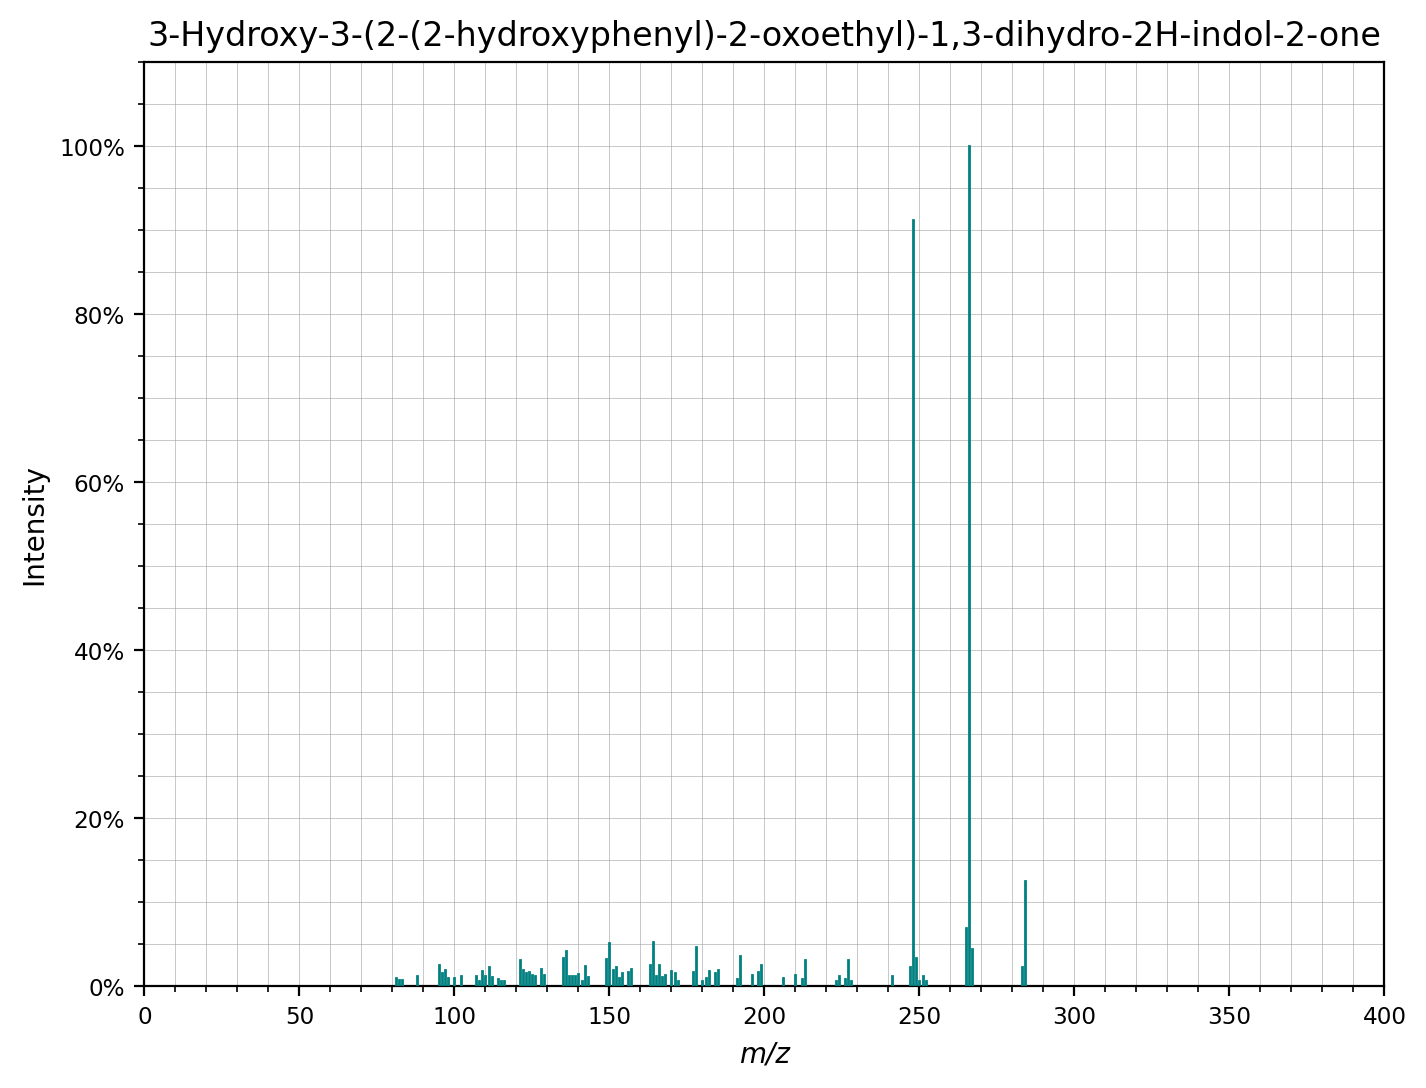

In [107]:
reloaded_spectra_list[0].plot()

# Load MSP file and set attributes, utils examples

In [25]:
np.random.seed(42)
random.seed(42)

In [26]:
nist_dataset_ms = load_from_msp(FILE_PATH_MS, metadata_harmonization=True)

In [27]:
nist_dataset_ms_list = []
for obj in nist_dataset_ms:
    nist_dataset_ms_list.append(obj)

In [54]:
nist_dataset_ms_list[0]

Spectrum(precursor m/z=284.09, 86 fragments between 81.0 and 284.0)

In [28]:
len(nist_dataset_ms_list)

574826

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': '1-(3-((2-(3,4-Dimethylphenoxy)ethyl)amino)-4-(nitro)phenyl)pyrrolidine'}, xlabel='m/z', ylabel='Intensity'>)

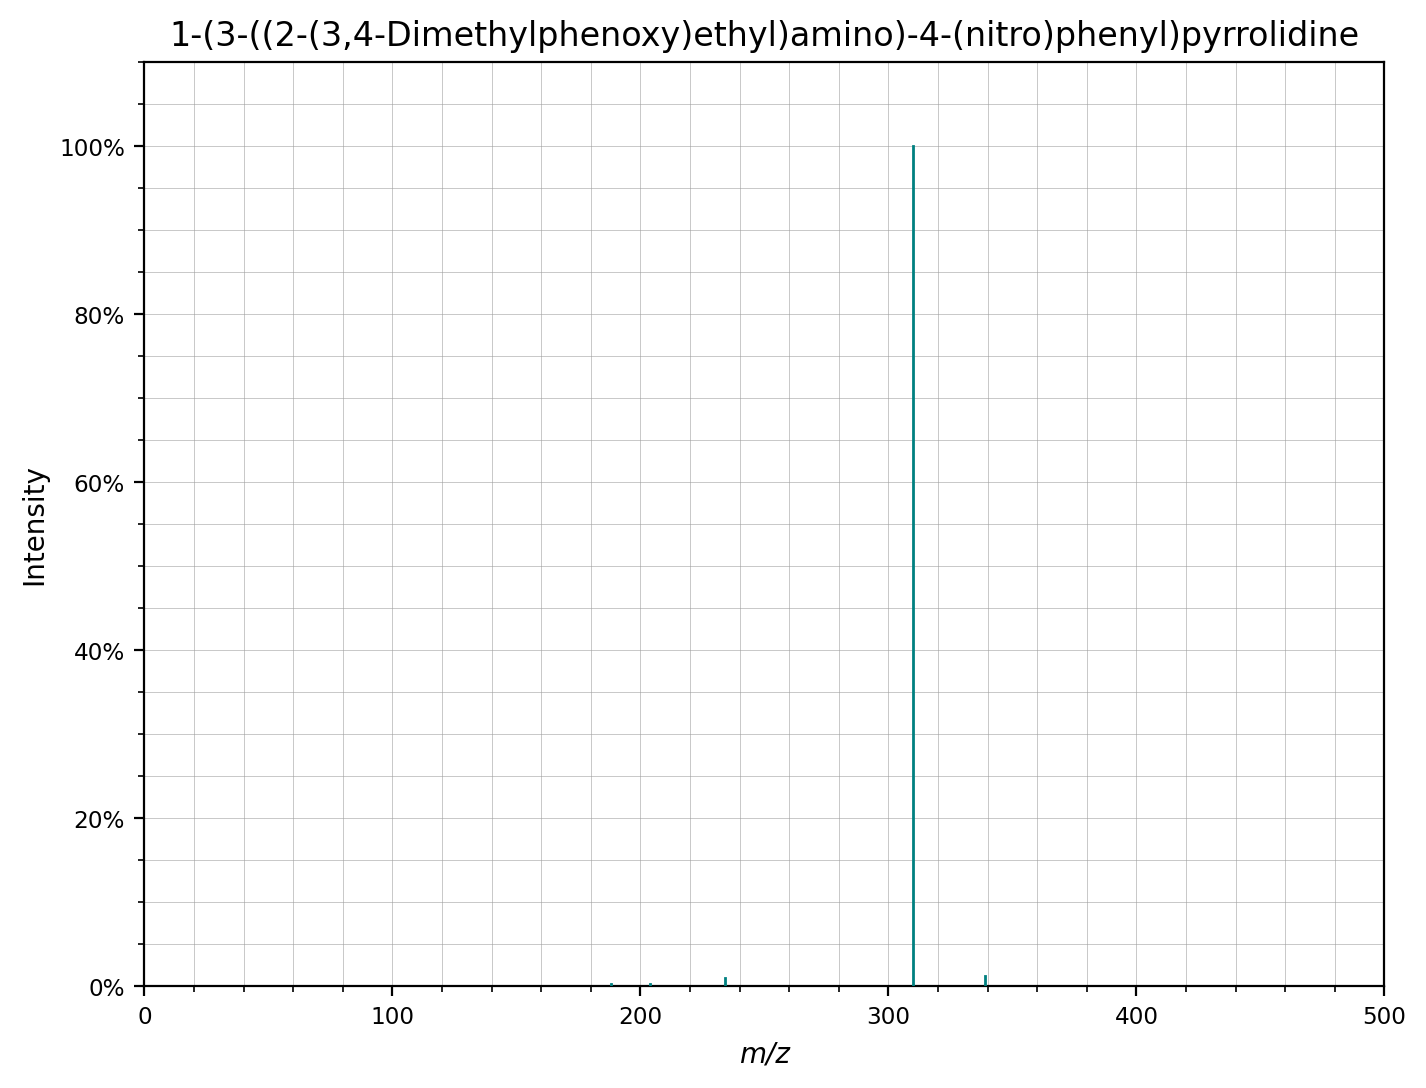

In [32]:
nist_dataset_ms_list[3].plot()

In [44]:
nist_dataset_ms_list[99].metadata_dict()

{'synon': '$:28ZFOUAZBWQSIIIA-UHFFFAOYSA-N',
 'formula': 'C10H6N2S2',
 'casno': '190579921',
 'nistno': '1000128',
 'comment': 'Provided by Thermo Finnigan, measured by John Halket, Centre for Chemical Sciences, University of London',
 'num_peaks': '33',
 'compound_name': '6-(2-Thienyl)-2-thioxo-1,2-dihydro-3-pyridinecarbonitrile',
 'nominal_mass': '217.99724',
 'precursor_mz': 219.0045}

In [46]:
type(nist_dataset_ms_list[99].metadata_dict())

dict

In [50]:
nist_dataset_ms_list[99].set("precursor_mz", 1.0)

Spectrum(precursor m/z=1.00, 33 fragments between 145.0 and 219.0)

In [51]:
nist_dataset_ms_list[99].metadata_dict()

{'synon': '$:28ZFOUAZBWQSIIIA-UHFFFAOYSA-N',
 'formula': 'C10H6N2S2',
 'casno': '190579921',
 'nistno': '1000128',
 'comment': 'Provided by Thermo Finnigan, measured by John Halket, Centre for Chemical Sciences, University of London',
 'num_peaks': '33',
 'compound_name': '6-(2-Thienyl)-2-thioxo-1,2-dihydro-3-pyridinecarbonitrile',
 'nominal_mass': '217.99724',
 'precursor_mz': 1.0}

In [70]:
spectrum = nist_dataset_ms_list[1234]

# Adding a new attribute, e.g., InChI key, to the spectrum's metadata
inchi_key = "InChIKey=ARAIBEBZBOPLMB-TZMJUOFKSA-N"  # Example InChI key
spectrum.set('inchi', inchi_key)

# Verify that the InChI key has been added
print(spectrum.metadata_dict())

{'synon': '$:28ARAIBEBZBOPLMB-TZMJUOFKSA-N', 'formula': 'C12H20N4O7', 'casno': '139110808', 'nistno': '1005299', 'comment': 'Allen GD. J CHROMATOGR B 732 (2) 383-393 1999', 'num_peaks': '13', 'compound_name': 'Zanamivir', 'nominal_mass': '332.1332', 'precursor_mz': 333.1405, 'inchi': 'InChIKey=ARAIBEBZBOPLMB-TZMJUOFKSA-N'}


In [71]:
nist_dataset_ms_list[1234].metadata_dict()

{'synon': '$:28ARAIBEBZBOPLMB-TZMJUOFKSA-N',
 'formula': 'C12H20N4O7',
 'casno': '139110808',
 'nistno': '1005299',
 'comment': 'Allen GD. J CHROMATOGR B 732 (2) 383-393 1999',
 'num_peaks': '13',
 'compound_name': 'Zanamivir',
 'nominal_mass': '332.1332',
 'precursor_mz': 333.1405,
 'inchi': 'InChIKey=ARAIBEBZBOPLMB-TZMJUOFKSA-N'}

In [30]:
# Print all available metadata keys for a specific spectrum
print(nist_dataset_ms_list[3].metadata.keys())

dict_keys(['synon', 'formula', 'casno', 'nistno', 'comment', 'num_peaks', 'compound_name', 'nominal_mass', 'precursor_mz'])


In [33]:
# Initialize sets to store unique values
unique_casno = set()
unique_formula = set()
unique_nistno = set()

# Iterate over each spectrum in the list
for spectrum in nist_dataset_ms_list:
    # Extract values from the metadata, use .get() to avoid KeyError if key is missing
    casno = spectrum.metadata.get('casno')
    formula = spectrum.metadata.get('formula')
    nistno = spectrum.metadata.get('nistno')
    
    # Add values to the sets (sets automatically handle uniqueness)
    if casno:
        unique_casno.add(casno)
    if formula:
        unique_formula.add(formula)
    if nistno:
        unique_nistno.add(nistno)

# Calculate counts of unique values
num_unique_casno = len(unique_casno)
num_unique_formula = len(unique_formula)
num_unique_nistno = len(unique_nistno)

# Print the counts
print(f"Number of unique CAS numbers (casno): {num_unique_casno}")
print(f"Number of unique formulas: {num_unique_formula}")
print(f"Number of unique NIST numbers (nistno): {num_unique_nistno}")

Number of unique CAS numbers (casno): 12037
Number of unique formulas: 8157
Number of unique NIST numbers (nistno): 574826


In [57]:
def parse_msp(file_path):
    spectra = []
    with open(file_path, 'r') as file:
        spectrum = {}
        synons = []
        for line in file:
            line = line.strip()
            if line.startswith("Name:"):
                if spectrum:
                    # If there is an existing spectrum, add it to the list
                    if synons:
                        spectrum['synon'] = synons
                    spectra.append(spectrum)
                    spectrum = {}
                    synons = []
                spectrum['compound_name'] = line.split(": ", 1)[1]
            elif line.startswith("Synon:"):
                synons.append(line.split(": ", 1)[1])
            elif line.startswith("Formula:"):
                spectrum['formula'] = line.split(": ", 1)[1]
            elif line.startswith("MW:"):
                spectrum['nominal_mass'] = line.split(": ", 1)[1]
            elif line.startswith("PrecursorMZ:"):
                spectrum['precursor_mz'] = line.split(": ", 1)[1]
            elif line.startswith("CASNO:"):
                spectrum['casno'] = line.split(": ", 1)[1]
            elif line.startswith("NISTNO:"):
                spectrum['nistno'] = line.split(": ", 1)[1]
            elif line.startswith("Comment:"):
                spectrum['comment'] = line.split(": ", 1)[1]
            elif line.startswith("Num peaks:"):
                spectrum['num_peaks'] = line.split(": ", 1)[1]
        
        # Add the last spectrum if the file does not end with a blank line
        if spectrum:
            if synons:
                spectrum['synon'] = synons
            spectra.append(spectrum)

    return spectra

In [58]:

# Use the custom parser to read your MSP file
file_path = '../data/NIST/nist_msms.MSP'
parsed_spectra = parse_msp(file_path)

# Example: Print out metadata of the first parsed spectrum
print(parsed_spectra[3])  # Adjust the index as needed

{'compound_name': '1-(3-((2-(3,4-Dimethylphenoxy)ethyl)amino)-4-(nitro)phenyl)pyrrolidine', 'formula': 'C20H25N3O3', 'nominal_mass': '355.189592', 'precursor_mz': '356.1969', 'casno': '298217488', 'nistno': '1000004', 'comment': 'Provided by Thermo Finnigan, measured by John Halket, Centre for Chemical Sciences, University of London', 'num_peaks': '5', 'synon': ['Benzenamine, N-[2-(3,4-dimethylphenoxy)ethyl]-2-nitro-5-(1-pyrrolidinyl)-', '$:17mol_Vial_ID=1000004', '$:03[M+H]+', '$:00MS2', '$:04356.1969', '$:06IT/ion trap', '$:07Thermo Finnigan LCQ Deca', '$:09HPLC', '$:10ESI', '$:05resonant relative/normalized 35 %', '$:11P', '$:08wideband', '$:28MHNGOEOPQMIYKD-UHFFFAOYSA-N']}


## MSMS2 

#### TODO, to many unidenfiable examples, needed another research

### function work same, however names are corrupted and also others information for identification are missing

In [133]:
nist_dataset_ms2 = load_from_msp(FILE_PATH_MS2, metadata_harmonization=True)

In [121]:
nist_dataset_ms2_list = []
for obj in nist_dataset_ms2:
    nist_dataset_ms2_list.append(obj)

In [21]:
nist_dataset_ms2_list[0]

Spectrum(precursor m/z=1122.64, 169 fragments between 342.0 and 1107.0)

In [22]:
len(nist_dataset_ms2_list)

90244

In [38]:
nist_dataset_ms2_list[27].metadata_dict()

{'synon': '$:11P',
 'formula': 'C114H180N30O29S',
 'casno': '0',
 'comment': 'Mods=0 NIST Mass Spectrometry Data Center',
 'num_peaks': '120',
 'compound_name': 'GIGKFLHSAKKFGKAFVGEIMNS/5',
 'nominal_mass': '2465.32532',
 'precursor_mz': 494.0723}

In [123]:
# Initialize sets to store unique values
unique_casno = set()
unique_formula = set()
unique_nistno = set()
unique_name = set()

# Iterate over each spectrum in the list
for spectrum in nist_dataset_ms2_list:
    # Extract values from the metadata, use .get() to avoid KeyError if key is missing
    casno = spectrum.metadata.get('casno')
    formula = spectrum.metadata.get('formula')
    nistno = spectrum.metadata.get('nistno')
    name = spectrum.metadata.get('compound_name')
    
    # Add values to the sets (sets automatically handle uniqueness)
    if casno:
        unique_casno.add(casno)
    if formula:
        unique_formula.add(formula)
    if nistno:
        unique_nistno.add(nistno)
    if name:
        unique_name.add(name)

# Calculate counts of unique values
num_unique_casno = len(unique_casno)
num_unique_formula = len(unique_formula)
num_unique_nistno = len(unique_nistno)
num_unique_name = len(unique_name)

# Print the counts
print(f"Number of unique CAS numbers (casno): {num_unique_casno}")
print(f"Number of unique formulas: {num_unique_formula}")
print(f"Number of unique NIST numbers (nistno): {num_unique_nistno}")
print(f"Number of unique names: {num_unique_name}")

Number of unique CAS numbers (casno): 799
Number of unique formulas: 1552
Number of unique NIST numbers (nistno): 154
Number of unique names: 6143
